In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

sns.set_style(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style('ticks', {'xtick.color': '.0', 'ytick.color': '.0', 
                       'grid.linestyle': '-', 'text.color': '.0'})


from utils_bin import utils ##IMPORTING HELPER FUNCTIONS

%load_ext autoreload
%autoreload 2

# 0. Bank Customer Churn Prediction - Introduction

This a notebook analyzing [this](https://www.kaggle.com/kmalit/bank-customer-churn-prediction/notebook) dataset from the Kaggle user [*Trustthedata*](https://www.kaggle.com/kmalit). The feature importance functions for numerical variables, as well as the GridSearchCV helper function, were developed by [*Pedro Leal*](https://www.kaggle.com/pmmleal) and adapted here.

Summary:
1. Importing data and checks;
2. Feature analysis and feature engineering;
3. Variable importance and statistical tests;
4. Handling data - splitting into subsets and transforming inputs;
5. Model definition, training and benchmark;
6. Analyzing results - Part I;
7. Analyzing results - Part II;
8. Restricting the analysis to relevant features
9. Conclusions;

# 1. Importing data and checks

**Main conclusions**

The features in the data set are `['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'BalanceEstSalaryRatio', 'TenureAgeRatio',
       'CreditScoreAgeRatio']`, with `'Exited'` being the target variable.

In [4]:
df = pd.read_csv('Churn_Modelling.csv', delimiter = ',')

In [5]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Figure out the shape of the dataframe.

In [6]:
df.shape

(10000, 14)

It is also convenient to know if the dataframe as any null values.

In [7]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no null values. Let us also check the number of unique values - this can tell us whether the variables are numerical or categorical.

In [8]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Those variables that have a small cardinality are probably categorical. Examples are "Tenure", "Exited", "HasCrCard".
Which features are irrelevant for the problem? RowNumber, CustomerId and Surname - people do not close their bank accounts because of their surname (and one would likely not have this data for privacy reasons).

In [9]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [10]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Figuring what are the data types of the elements in the columns

In [11]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Although some of the variables here are integers, their cardinality is low, therefore they are likely categorical. A better view:

In [12]:
pd.concat((df.dtypes, df.nunique(), df.nunique() < 20), axis = 1)

,0,1,2
CreditScore,int64,460,False
Geography,object,3,True
Gender,object,2,True
Age,int64,70,False
Tenure,int64,11,True
Balance,float64,6382,False
NumOfProducts,int64,4,True
HasCrCard,int64,2,True
IsActiveMember,int64,2,True
EstimatedSalary,float64,9999,False


# 2. Feature analysis and engineering

**Main conclusions**

From the *categorical* variables: 
1. German users are more likely to have left than otherwise.
2. Idem for female customers. 
3. Having a credit card does not seem to have played a role. 
4. Members that are not active are more likely to leave the platform.

The proportion of churned customers per country is inversely proportional to the total number of customers in that country. If this sample of the data is representative of the actual bank customer distribution, it may mean there is more friction for a customer to leave the bank once it gains enough presence in a country.

From the *continuous* variables: 
1. Credit score does not seem to impact whether a client exits or not (looking at the median), although there are more outliers on the distribution of exited customers (tilted towards lower values);
2. Customers that exited seem to be older;
3. There is a larger variance w.r.t to tenure for exiting customers than remaining ones;
4. The median value of the balance appears to be nearly identical for both distributions, but remaining customers display a much wider range of values;
5. Number of products and estimated salary appear to have no difference;

Since older customers are more likely to exit, a targeted policy for these might be worthwhile. Better retention strategy is needed in light of 1) old customers are exiting, as well as new, 2) customers with large balances are exiting, which could make it harder for the bank to lend.

In [13]:
print(f"Percentage of staying customers: {sum(df['Exited'] == 0)/len(df['Exited'])}")
print(f"Percentage of leaving customers: {sum(df['Exited'] == 1)/len(df['Exited'])}")   

Percentage of staying customers: 0.7963
Percentage of leaving customers: 0.2037


Displaying the two classes as a function of different categorical inputs:

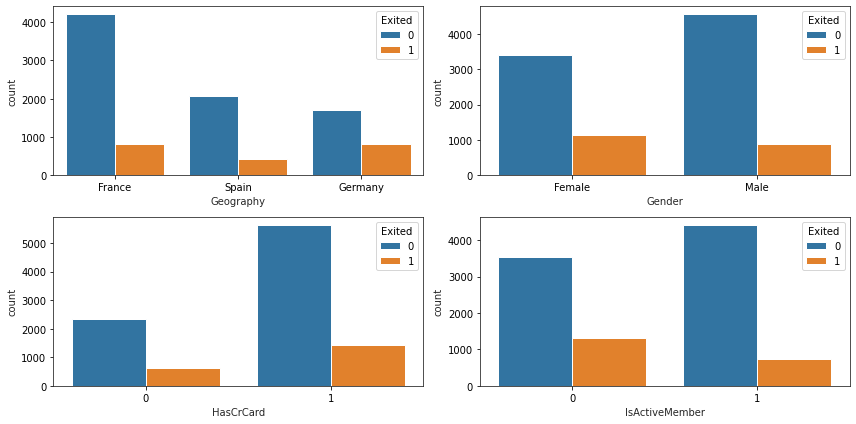

In [14]:
cat_feature_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
fig, axarr = plt.subplots(2, 2, figsize=(12, 6), facecolor = (1,1,1))
sns.countplot(x= cat_feature_list[0], hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x= cat_feature_list[1], hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x= cat_feature_list[2], hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x= cat_feature_list[3], hue = 'Exited',data = df, ax=axarr[1][1])
plt.tight_layout()
plt.show()

In [15]:
for ele in cat_feature_list:
    print('-'*20)
    print(df.groupby(ele).agg({'Exited':'sum'})/df.groupby(ele).agg({'Exited':'count'}))
    print('-'*20)

--------------------
             Exited
Geography          
France     0.161548
Germany    0.324432
Spain      0.166734
--------------------
--------------------
          Exited
Gender          
Female  0.250715
Male    0.164559
--------------------
--------------------
             Exited
HasCrCard          
0          0.208149
1          0.201843
--------------------
--------------------
                  Exited
IsActiveMember          
0               0.268509
1               0.142691
--------------------


Conclusions on the categorical variables: 
1. German users are more likely to have left than otherwise.
2. Idem for female customers. 
3. Having a credit card does not seem to have played a role. 
4. Members that are not active are more likely to leave the platform.

Other conclusions: The proportion of churned customers is inversely proportional to the total number of customers. If this sample of the data is representative of the actual bank customer distribution, it may mean that there is more friction for a customer to leave the bank once it gains enough presence in a country.

Repeating the study for the continuous variables:

In [16]:
s_list = [ele for ele in df.columns if ele not in cat_feature_list]
num_feature_list = s_list[:-1] ##Exclude the target variable

In [17]:
num_feature_list

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

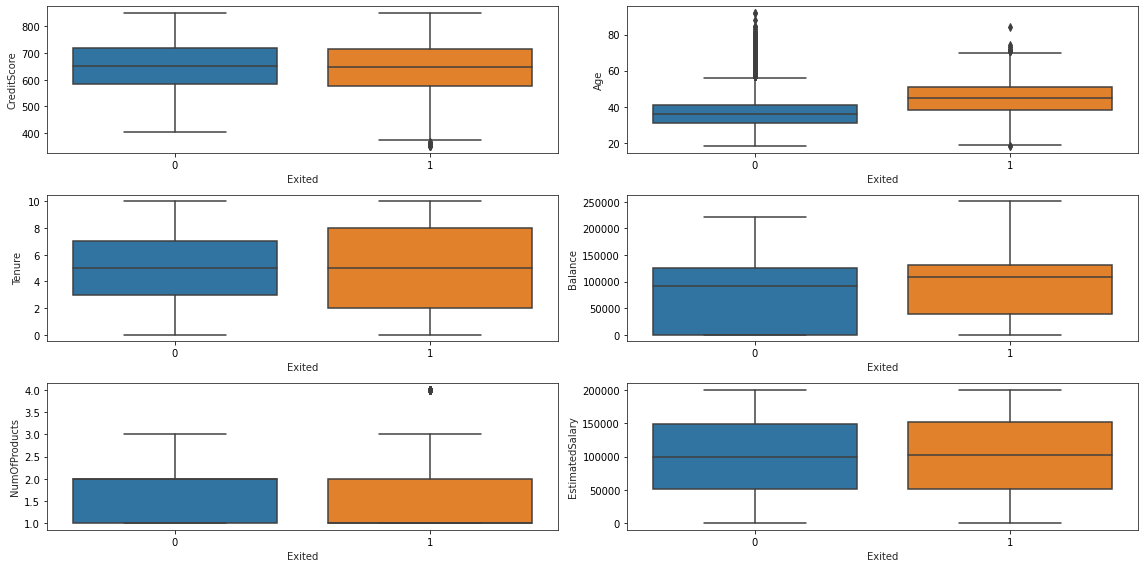

In [18]:
fig, axarr = plt.subplots(3, 2, figsize=(16, 8))
sns.boxplot(y= num_feature_list[0], x = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y= num_feature_list[1], x = 'Exited',data = df, ax=axarr[0][1])
sns.boxplot(y= num_feature_list[2], x = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y= num_feature_list[3], x = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y= num_feature_list[4], x = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y= num_feature_list[5], x = 'Exited',data = df, ax=axarr[2][1])
plt.tight_layout()
plt.show()

Conclusions: 
1) Credit score does not seem to impact whether a client exits or not (looking at the median), although there are more outliers on the distribution of exited customers (tilted towards lower values);
2) Customers that exited seem to be older;
3) There is a larger variance w.r.t to tenure for exiting customers than remaining ones;
4) The median value of the balance appears to be nearly identical for both distributions, but remaining customers display a much wider range of values;
5) Number of products and estimated salary appear to have no difference;

Other conclusions: Since older customers are more likely to exit, a targeted policy for these might be worthwhile. Better retention strategy is needed in light of 1) old customers are exiting, as well as new, 2) customers with large balances are exiting, making it harder for the bank to lend. See more below.

Let us do some feature engineering and check if these are more useful than the original features:

1 - We saw above that the estimated salary play almost no role in separating customers. At the same time, we saw that balance was slightly
tilted to the upside for exiting customers. One way to possibly make the former feature more interesting is by combining it with the latter.

In [19]:
df['BalanceEstSalaryRatio'] = df['Balance']/df['EstimatedSalary']

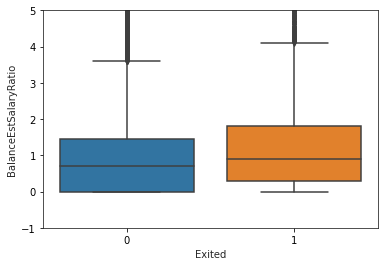

In [20]:
sns.boxplot(y= 'BalanceEstSalaryRatio', x = 'Exited',data = df)
plt.ylim(-1,5) ##We need to limit the range because there are plenty of outliers (this new var has a very large range - see below).
## That is why it is not very convenient to do the inverse, as the features become extremely compressed.
plt.show()

In [21]:
df['BalanceEstSalaryRatio'].describe()

count    10000.000000
mean         3.878703
std        108.337260
min          0.000000
25%          0.000000
50%          0.747002
75%          1.514022
max      10614.655440
Name: BalanceEstSalaryRatio, dtype: float64

In [22]:
pd.concat((df['BalanceEstSalaryRatio'][df['Exited'] == 0].describe(), \
    df['BalanceEstSalaryRatio'][df['Exited'] == 1].describe()), axis = 1)

,BalanceEstSalaryRatio,BalanceEstSalaryRatio
count,7963.000000,2037.000000
mean,2.478339,9.352977
std,14.803568,238.215765
min,0.000000,0.000000
25%,0.000000,0.284769
50%,0.703392,0.887100
75%,1.446481,1.820143
max,611.268941,10614.655440


2 - Adjust the fact that tenure is a function of the age (barring extraordinary circumstances, young people are likely to have a short tenure)
Note that this ratio has to be smaller than one.

In [23]:
df['TenureAgeRatio'] = df['Tenure']/(df['Age'] - (df['Age'].min()-1))

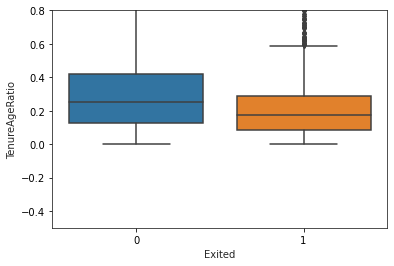

In [24]:
sns.boxplot(y= 'TenureAgeRatio', x = 'Exited',data = df)
plt.ylim(-0.5,0.8) ##We need to limit the range because there are plenty of outliers (this new var has a very large range - see below).
## That is why it is not very convenient to do the inverse, as the features become extremely compressed.
plt.show()

The distributions look the opposite of above because Age is now in the denominator.

In [25]:
df['TenureAgeRatio'].describe()

count    10000.000000
mean         0.310192
std          0.399528
min          0.000000
25%          0.111111
50%          0.231664
75%          0.391304
max         10.000000
Name: TenureAgeRatio, dtype: float64

In [26]:
pd.concat((df['TenureAgeRatio'][df['Exited'] == 0].describe(), \
    df['TenureAgeRatio'][df['Exited'] == 1].describe()), axis = 1)

,TenureAgeRatio,TenureAgeRatio
count,7963.000000,2037.000000
mean,0.332920,0.221346
std,0.417805,0.302265
min,0.000000,0.000000
25%,0.125000,0.083333
50%,0.250000,0.176471
75%,0.421053,0.285714
max,10.000000,7.000000


3- Adjust Credit Score for age - elder people are likely to have a higher credit score.

In [27]:
df['CreditScoreAgeRatio'] = df['CreditScore']/(df['Age'] - (df['Age'].min()-1))

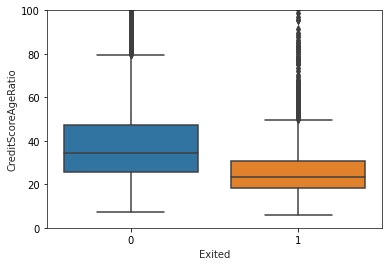

In [28]:
sns.boxplot(y= 'CreditScoreAgeRatio', x = 'Exited',data = df)
plt.ylim(0,100) ##We need to limit the range because there are plenty of outliers (this new var has a very large range - see below).
## That is why it is not very convenient to do the inverse, as the features become extremely compressed.
plt.show()

The distributions look the opposite of above because Age is now in the denominator.

In [29]:
df['CreditScoreAgeRatio'].describe()

count    10000.000000
mean        40.209282
std         42.577027
min          6.089552
25%         23.415441
50%         31.937500
75%         44.428571
max        844.000000
Name: CreditScoreAgeRatio, dtype: float64

In [30]:
pd.concat((df['CreditScoreAgeRatio'][df['Exited'] == 0].describe(), \
    df['CreditScoreAgeRatio'][df['Exited'] == 1].describe()), axis = 1)

,CreditScoreAgeRatio,CreditScoreAgeRatio
count,7963.000000,2037.000000
mean,43.202242,28.509266
std,45.171306,27.413058
min,7.225352,6.089552
25%,25.830460,18.200000
50%,34.434783,23.241379
75%,47.333333,30.842105
max,844.000000,674.000000


A final check on the distributions of the numerical features:

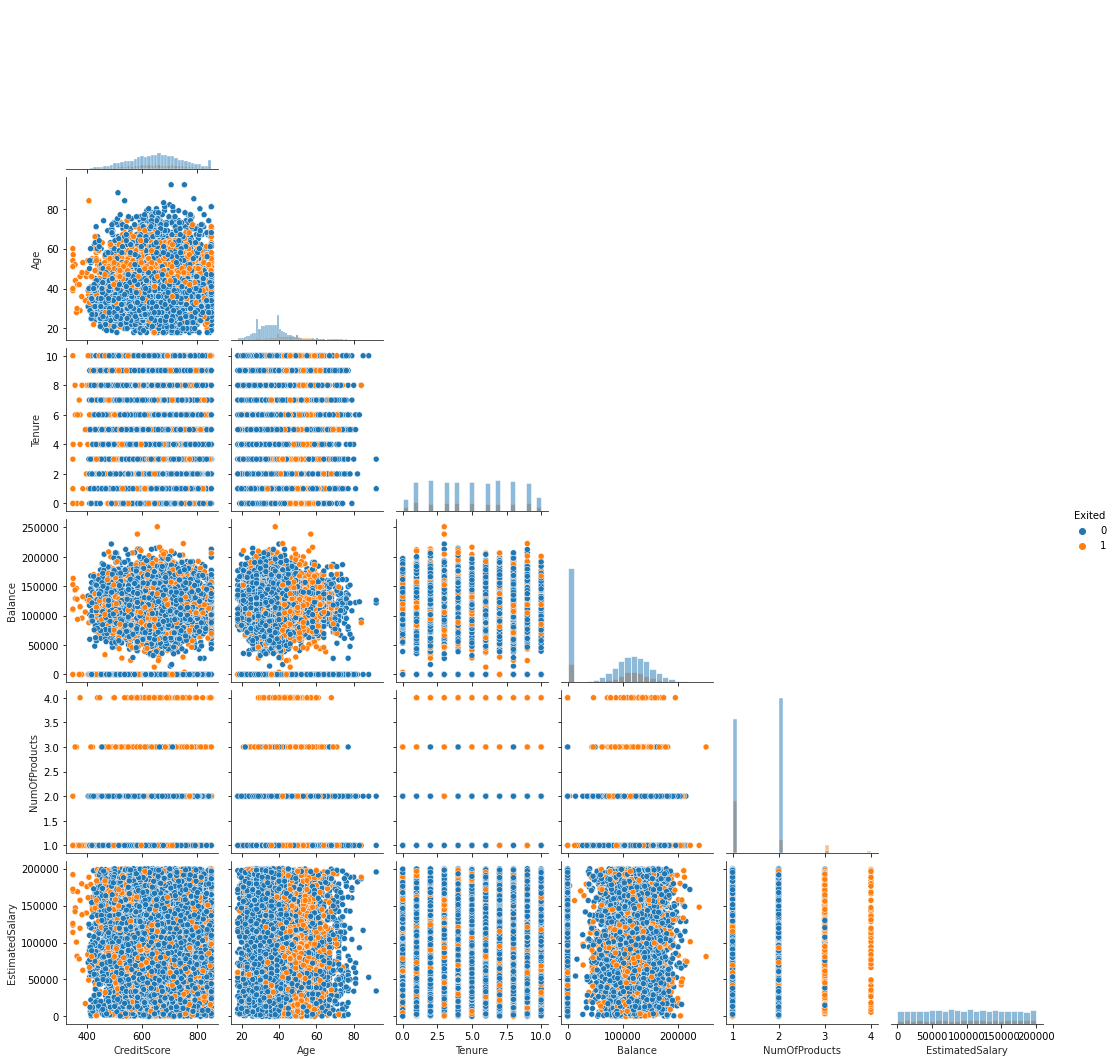

In [31]:
sns.pairplot(df[num_feature_list + ['Exited']],hue='Exited',corner=True,diag_kind='hist')
plt.show()

# 3. Variable importance and statistical tests

**Main conclusions**

1. Feature importance indicates that the most important variables are `Age`, `NumOfProducts`, `EstimatedSalary`, `CreditScore` and `Balance`.
2. A Kolmogorov-Smirnov test indicates that  `Age`, `NumOfProducts`, `CreditScore` and `Balance` display statistically significant distribution differences between staying and exiting customers. `EstimatedSalary` and `Tenure` do not.
3. A chi-squared test indicates that `Geography`, `Gender`, `IsActiveMember` have statistically significant distribution differences. `HasCreditCard` does not.

These are consistent with the feature analysis conducted above.

Before we start manipulating the data, it is convenient to run a quick feature importance test using extra/random forest trees and double-check this with a Kolmogorov-Smirnov test, which tells us whether the distribution of a numerical variable is statistically different for a different value of the target variable. These features are likely to be good separators. We then run a similar test (chi-squared) on the categorical variables.

In [32]:
f_num_feature_list = num_feature_list + ['BalanceEstSalaryRatio', 'TenureAgeRatio', 'CreditScoreAgeRatio']

In [33]:
X, y = df[f_num_feature_list] , df['Exited']

--------------------
Feature ranking (ExtraTrees):
1. CreditScore. 1 (0.162273)
2. Age. 4 (0.144316)
3. Tenure. 8 (0.138007)
4. Balance. 0 (0.109507)
5. NumOfProducts. 5 (0.109043)
6. EstimatedSalary. 3 (0.099237)
7. BalanceEstSalaryRatio. 7 (0.093579)
8. TenureAgeRatio. 6 (0.079444)
9. CreditScoreAgeRatio. 2 (0.064595)




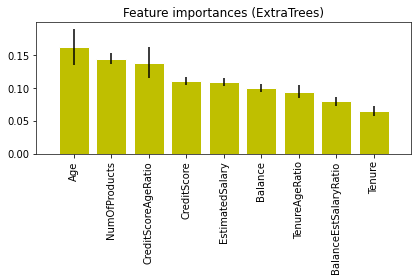

In [34]:
ft_vars , ft_indices, ft_importances = utils.feature_importance_indicator(X,y, 'Exited')

--------------------
Feature ranking (RandomTrees):
1. CreditScore. 8 (0.160338)
2. Age. 1 (0.148330)
3. Tenure. 4 (0.130786)
4. Balance. 5 (0.116878)
5. NumOfProducts. 0 (0.113492)
6. EstimatedSalary. 3 (0.102266)
7. BalanceEstSalaryRatio. 6 (0.094246)
8. TenureAgeRatio. 7 (0.088215)
9. CreditScoreAgeRatio. 2 (0.045450)




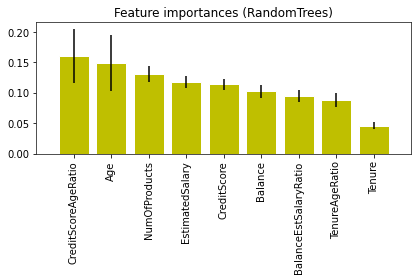

In [35]:
ft_vars_rt , ft_indices_rt, ft_importances_rt = utils.feature_importance_indicator(X,y, 'Exited', 'RandomTrees')

Interestingly, the engineered features do not seem to play much of a role, but there seems to be some consistency in the feature ranking across the two methods. We can also use permutation importance - see [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) why this might be a good idea.

--------------------
1. NumOfProducts. (0.129330)
2. Age. (0.128890)
3. CreditScoreAgeRatio. (0.093270)
4. Balance. (0.072670)
5. BalanceEstSalaryRatio. (0.059110)
6. TenureAgeRatio. (0.050680)
7. EstimatedSalary. (0.048470)
8. CreditScore. (0.048100)
9. Tenure. (0.015010)




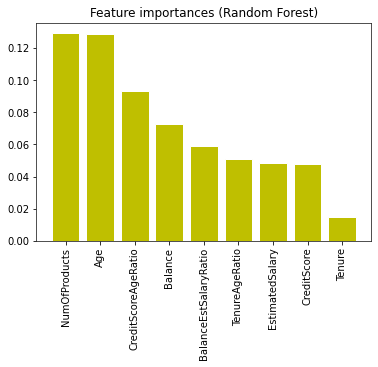

In [36]:
utils.feature_importance_permutation(X,y, 'Exited')

Again, consistent with the above results. Finally, we perform the KS test:

In [37]:
num_feature_list_ex_num_prod = [ele for ele in num_feature_list if ele != 'NumOfProducts']

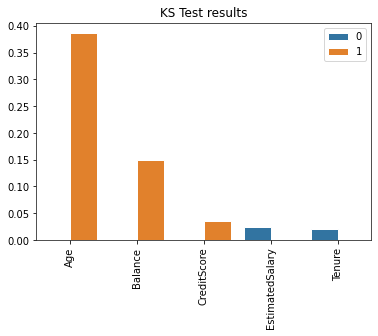

In [38]:
utils.KS_test(df[num_feature_list_ex_num_prod + ['Exited']], 'Exited')

Age, number of products, balance and credit score display statistically significant differences, while estimated salary and tenure do not.

In [39]:
irr_num_f_list = ['EstimatedSalary', 'Tenure']

It is also insightful to run a chi-squared test on the categorical variables and check if these are statistically different (depending on the value of the target):

In [40]:
for ele in cat_feature_list:
    utils.chi_squared_test(df, ele, 'Exited')



Cat var 1: Geography , Cat var 2: Exited


--------------------
Probability = 0.950, critical stat =   6, statistic = 301
Dependent (reject H0)
--------------------
--------------------
Significance (alpha) = 0.050, p =   0
Dependent (reject H0)
--------------------


Cat var 1: Gender , Cat var 2: Exited


--------------------
Probability = 0.950, critical stat =   4, statistic = 113
Dependent (reject H0)
--------------------
--------------------
Significance (alpha) = 0.050, p =   0
Dependent (reject H0)
--------------------


Cat var 1: HasCrCard , Cat var 2: Exited


--------------------
Probability = 0.950, critical stat =   4, statistic =   0
Independent (fail to reject H0)
--------------------
--------------------
Significance (alpha) = 0.050, p =   0
Independent (fail to reject H0)
--------------------


Cat var 1: IsActiveMember , Cat var 2: Exited


--------------------
Probability = 0.950, critical stat =   4, statistic = 243
Dependent (reject H0)
--------------------
----

This confirms the above intuition that having a credit card was not an indicator of whether or not the client would likely exit the bank.

In [41]:
irr_cat_f_list = ['HasCrCard']

# 4. Handling data - splitting into subsets and transforming inputs 

Training test split - it is important to guarantee that we have a balanced dataset (by using stratify).

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Exited'],axis=1,inplace=False), 
                                                    df['Exited'], test_size=0.20, random_state=42,shuffle=True,
                                                    stratify=df['Exited'])

In [43]:
## We can probably build a pipeline here to save some work when repeating the process for the test subset

Start preparing the data before model fitting - note that we do this AFTER splitting the data to avoid any instance of data leakage. In this case, some of the categorical features are already encoded ("HasCrCard" and "IsActiveMember"), while "Geography" and "Gender" are not. These two need to be encoded:

In [44]:
X_train_num = X_train[num_feature_list]

In [45]:
df[cat_feature_list].head()

,Geography,Gender,HasCrCard,IsActiveMember
0,France,Female,1,1
1,Spain,Female,0,1
2,France,Female,1,0
3,France,Female,0,0
4,Spain,Female,1,1


In [46]:
one_h_enc = OneHotEncoder()

In [47]:
Xdata_train_cat_enc = one_h_enc.fit_transform(X_train[cat_feature_list]\
                                        .select_dtypes(include = "object"))

In [48]:
print(one_h_enc.categories_)
print(one_h_enc.get_feature_names_out())

[array(['France', 'Germany', 'Spain'], dtype=object), array(['Female', 'Male'], dtype=object)]
['Geography_France' 'Geography_Germany' 'Geography_Spain' 'Gender_Female'
 'Gender_Male']


In [49]:
X_train_cat_enc = pd.DataFrame(columns = one_h_enc.get_feature_names_out(), index = X_train.index, 
             data = Xdata_train_cat_enc.toarray())
X_train_cat_enc = X_train_cat_enc.join(X_train[cat_feature_list]\
                                        .select_dtypes(exclude = "object"))
X_train_cat_enc.drop(columns = ["Gender_Male"], inplace = True)

We can now address the numerical variables.

In [50]:
rb_scaler = RobustScaler()

In [51]:
Xdata_train_num_enc = rb_scaler.fit_transform(X_train[num_feature_list])

In [52]:
X_train_num_enc = pd.DataFrame(columns = X_train[num_feature_list].columns, index = X_train.index, 
             data = Xdata_train_num_enc)

In [53]:
X_train_f = X_train_num_enc.join(X_train_cat_enc)

After having transformed the input variables, let us re-run the feature importance tests and see how do these compare with the former.

--------------------
1. Age. (0.167125)
2. NumOfProducts. (0.110975)
3. Balance. (0.089675)
4. IsActiveMember. (0.087925)
5. CreditScore. (0.056412)
6. EstimatedSalary. (0.055825)
7. Geography_Germany. (0.055587)
8. Gender_Female. (0.047225)
9. Tenure. (0.044550)
10. Geography_France. (0.023787)
11. HasCrCard. (0.023550)
12. Geography_Spain. (0.013000)




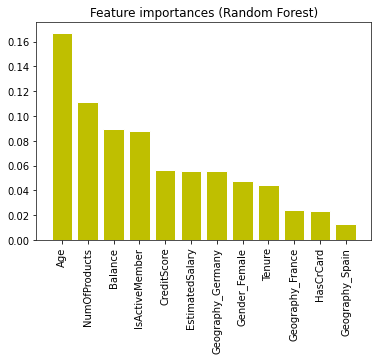

In [54]:
utils.feature_importance_permutation(X_train_f,y_train, 'Exited')

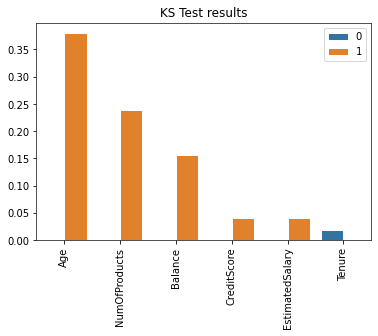

In [55]:
utils.KS_test(X_train_num_enc.join(y_train), 'Exited')

Apparently there is no difference before and after normalizing the numerical variables.

Building the test set:

In [56]:
X_test_cat_enc = pd.DataFrame(columns = one_h_enc.get_feature_names_out(), index = X_test.index, 
             data = one_h_enc.transform(X_test[cat_feature_list].select_dtypes(include = "object")).toarray()
            )
X_test_cat_enc = X_test_cat_enc.join(X_test[cat_feature_list]\
                                        .select_dtypes(exclude = "object"))
X_test_cat_enc.drop(columns = ["Gender_Male"], inplace = True)

In [57]:
X_test_num_enc = pd.DataFrame(columns = X_train[num_feature_list].columns, index = X_test.index, 
             data = rb_scaler.fit_transform(X_test[num_feature_list]))

In [58]:
X_test_f = X_test_num_enc.join(X_test_cat_enc)

# 5. Model definition, training and benchmark

The tunable parameters are:
1. The amount of regularization, given by C (the smaller it is, there more regularization);
2. Whether we correct for the fact that the dataset is unbalanced - Doing so uses the values of y to adjust weights to be inversely proportional to the class frequencies in the input data;
3. For the Support Vector Classifier, the type of kernel used by the model;

In [59]:
models1 = {
    'LogisticRegression' : LogisticRegression(solver= 'newton-cg', max_iter = 1000),
    'RandomForestClassifier' : RandomForestClassifier(),
    'SVC' : SVC()
}

params1 = {
    'LogisticRegression' : {'C' : [0.01, 1, 10, 100], 
                            'class_weight' : [None, 'balanced']},
    'RandomForestClassifier': {'n_estimators': [100, 500],
                               'class_weight' : [None, 'balanced']},
    'SVC' : {'C' : [0.01, 1, 10, 100],
             'kernel' : ['rbf'],
             'class_weight' : [None, 'balanced']}
}

Having tested with a SVC with linear kernel and knowing that the performance is not adequate (score below of that of logistic regression).

In [60]:
utils.EstimatorGridSearch(X_train_f, y_train, models1, params1, score_method = "accuracy") ##To make the default score method explicit

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,Estimator,Min_score,Mean_score,Max_score,Std_score,C,class_weight,n_estimators,kernel
9,RandomForestClassifier,0.853125,0.863125,0.875625,0.008033,NaN,None,500,NaN
8,RandomForestClassifier,0.85,0.86225,0.871875,0.007832,NaN,None,100,NaN
11,RandomForestClassifier,0.849375,0.86075,0.87375,0.00837,NaN,balanced,500,NaN
10,RandomForestClassifier,0.850625,0.8595,0.87125,0.008601,NaN,balanced,100,NaN
16,SVC,0.848125,0.857125,0.86875,0.008372,10,None,NaN,rbf
14,SVC,0.84625,0.85625,0.86625,0.007935,1,None,NaN,rbf
18,SVC,0.831875,0.83825,0.848125,0.006572,100,None,NaN,rbf
2,LogisticRegression,0.806875,0.81025,0.8125,0.001961,1,None,NaN,NaN
4,LogisticRegression,0.806875,0.81025,0.8125,0.001961,10,None,NaN,NaN
6,LogisticRegression,0.806875,0.810125,0.8125,0.001912,100,None,NaN,NaN


Using solely the sample frequencies of `y_train`, we can build a naïve classifier that predicts with probability $p$ that a customer has exited and with probability $1-p$ that has not exited.

In [61]:
p_ex_training = sum(y_train)/len(y_train)

# 6. Analyzing results - Part I

**Goal**: Assuming the situation where the bank does not look at expenses to keep customers from leaving, the goal is to identify all possible exiting customers, even if this means a larger number of false positives. Therefore, we want avoid false negatives at all costs. This is an example of an asymmetric risk function: we are must more sensible to false negatives rather than false positives.

In practice, if the bank were to implement preventive measures, with clients referred as potential "exiters" followed by a sales assistant, providing them with personalized support and/or better contract conditions. This would represent an extra cost for the bank, but with the benefit of retaining more of its clientele. Of course, this depends both on
1. The type of customer (e.g those with savings accounts with less than 1000€, or those with an active management investment portfolio worth more than 1M€) and 
2. How competitive the local banking market is (e.g, customers in a less competitive banking market are less likely to leave their bank).

among other factors.

**Main conclusions**: The first set of results is not very inspiring because the number of customers who exited is not being correctly captured and the number of false negatives is too large. This is the figure we want to optimize - we would gladly trade off a large number of false negatives for false positives. Therefore, we shall use a $F_{\beta}$ scorer (see details below) in cross-validation for model selection rather than the default accuracy.

This highlights the very important fact that overall performance of a model is extremely metric dependent. Suppose, for example, the extreme scenario where the banking market is very uncompetitive and that labor and capital for client support are very expensive - it may be that the bank is be interested in retaining current clients, but not at the expense of higher costs. This bank could then opt to focus on a metric with less emphasis on false negatives (which would be tantamount to a lower threshold for action, e.g. only engage with the client when there is a 70% of likelihood of her leaving, rather than 10%). 

Regarding the models in more detail:
1. The Support Vector Classifier (ROC (f2-) score: 0.82 (0.71)) outperforms the naïve benchmark (ROC (f2-) score: 0.50 (0.67)) in both metrics but the Logistic Regression (ROC (f2-) score: 0.77 (0.58)) does not.
2. However, these models were selected using accuracy. Therefore, one should expect better performance once we change to $F_{\beta}$.

### Concepts

Now that we have a simple set of models fitted, let us evaluate performance in more detail and in the context of the problem. To do this, the following tools are important:

1. Use a confusion matrix to understand the number of false positives and negatives. Implicitly, one is computing the precision and recall, which are key metrics of the problem at hand (see details below).  
2. Following the point above, we use another visual representation - the ROC curve.

0. Positive / negative - Positive here means that an element displays a certain characteristic. Here it is leaving the bank, but a common example in statistics is having a disease.
1. False positive (negative) (FP/FN) - these are essentially misclassifications - False positive is an instance where the model predicts an element belongs to the positive class (e.g., leaving the bank) but the element does not. False negative is the exact opposite - the model predicts an element does not belong to the positive class but the element does.
2. ROC curve - see details [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

## Parametric methods - Support Vector Classifier

In [123]:
svc_clf = SVC(C=10, class_weight= None, kernel= 'rbf', probability= True)
svc_clf.fit(X_train_f,y_train)

SVC(C=10, probability=True)

In [124]:
print(f"Train ROC score: {round(roc_auc_score(y_train,svc_clf.predict_proba(X_train_f)[:,-1]),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test ROC score: {round(roc_auc_score(y_test,svc_clf.predict_proba(X_test_f)[:,-1]),3)}")

Train ROC score: 0.905
Test ROC score: 0.821


In [125]:
print(f"Train f-2 score: {round(fbeta_score(y_train,svc_clf.predict(X_train_f), average='macro', beta=2),3)}")
print(f"Test f-2 score: {round(fbeta_score(y_test,svc_clf.predict(X_test_f), average='macro', beta=2),3)}")

Train f-2 score: 0.757
Test f-2 score: 0.719


In [126]:
disp_train = ConfusionMatrixDisplay(confusion_matrix(y_train, svc_clf.predict(X_train_f)))
disp_test = ConfusionMatrixDisplay(confusion_matrix(y_test, svc_clf.predict(X_test_f)))

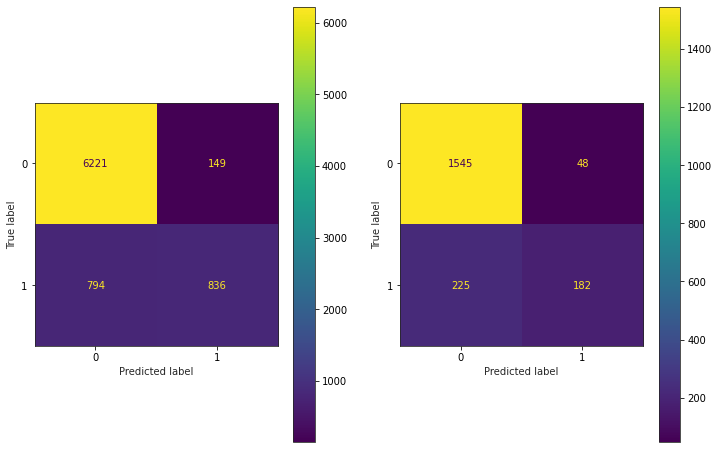

In [127]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))
disp_train.plot(ax = ax.flatten()[0])
disp_test.plot(ax = ax.flatten()[1])
plt.show()

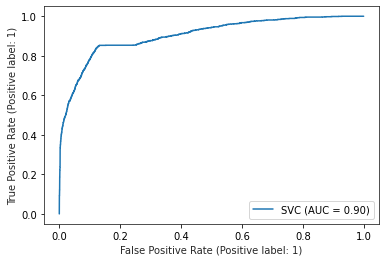

In [128]:
RocCurveDisplay.from_estimator(svc_clf, X_train_f,\
                               y_train)
plt.show()

## Parametric methods - Logistic Regression

In [129]:
lr_clf = LogisticRegression(class_weight = None, C = 1)
lr_clf.fit(X_train_f,y_train)

LogisticRegression(C=1)

In [130]:
print(f"Train ROC score: {round(roc_auc_score(y_train,lr_clf.predict_proba(X_train_f)[:,-1]),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test ROC score: {round(roc_auc_score(y_test,lr_clf.predict_proba(X_test_f)[:,-1]),3)}")

Train ROC score: 0.765
Test ROC score: 0.775


In [131]:
print(f"Train f-2 score: {round(fbeta_score(y_train,lr_clf.predict(X_train_f), average='macro', beta=2),3)}")
print(f"Test f-2 score: {round(fbeta_score(y_test,lr_clf.predict(X_test_f), average='macro', beta=2),3)}")

Train f-2 score: 0.589
Test f-2 score: 0.576


In [132]:
disp_train = ConfusionMatrixDisplay(confusion_matrix(y_train, lr_clf.predict(X_train_f)))
disp_test = ConfusionMatrixDisplay(confusion_matrix(y_test, lr_clf.predict(X_test_f)))

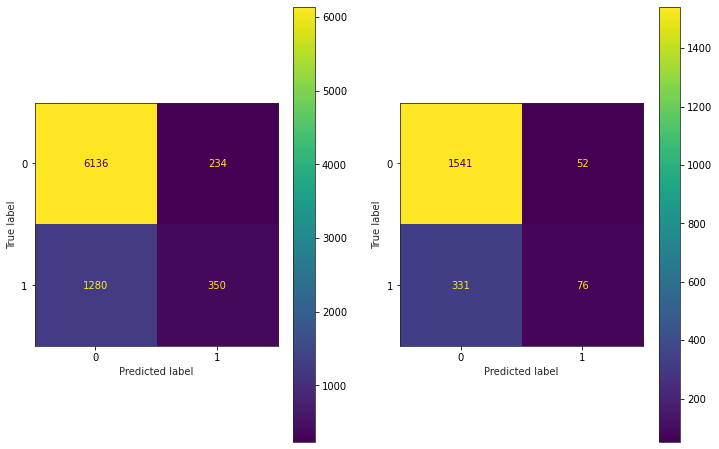

In [133]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))
disp_train.plot(ax = ax.flatten()[0])
disp_test.plot(ax = ax.flatten()[1])
plt.show()

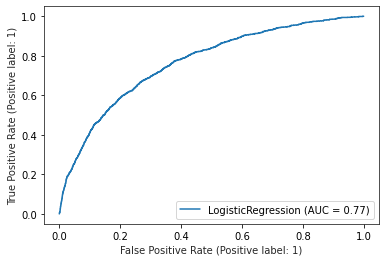

In [134]:
RocCurveDisplay.from_estimator(lr_clf, X_train_f,\
                               y_train)
plt.show()

## Benchmark

In [74]:
naive_clf_train = utils.naive_classifier(y_train, p_ex_training)
naive_clf_test = utils.naive_classifier(y_test, p_ex_training)

In [75]:
print(f"Train ROC score: {round(roc_auc_score(y_train,naive_clf_train),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test ROC score: {round(roc_auc_score(y_test,naive_clf_test),3)}")

Train ROC score: 0.509
Test ROC score: 0.503


In [76]:
print(f"Train f-2 score: {round(fbeta_score(y_train,naive_clf_train, average='macro', beta=2),3)}")
print(f"Test f-2 score: {round(fbeta_score(y_test,naive_clf_test, average='macro', beta=2),3)}")

Train f-2 score: 0.68
Test f-2 score: 0.682


In [77]:
disp_train = ConfusionMatrixDisplay(confusion_matrix(y_train, naive_clf_train))
disp_test = ConfusionMatrixDisplay(confusion_matrix(y_test, naive_clf_test))

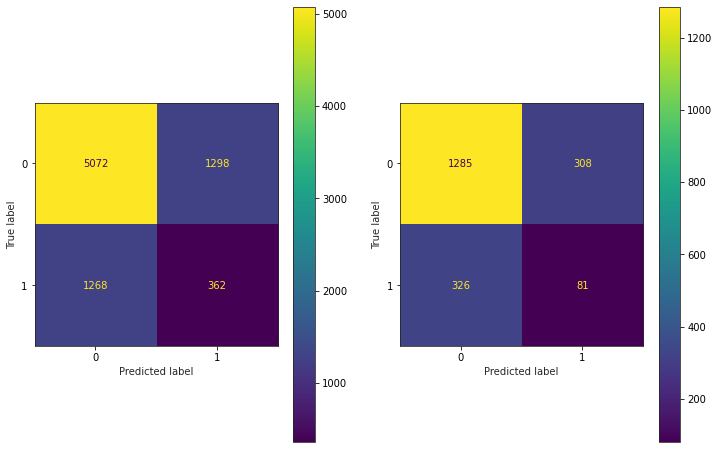

In [78]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))
disp_train.plot(ax = ax.flatten()[0])
disp_test.plot(ax = ax.flatten()[1])
plt.show()

## First set of conclusions

The first set of results is not very inspiring because the number of customers who exited is not being correctly captured and the number of false negatives is too large. This is the figure we want to optimize - we would gladly trade off a large number of false negatives for false positives.

To that end, we are going back to the model training phase, this time using the f2 score.

**Concepts**: 

**Recall** - Number of **true** positive results divided by the number of **all** the samples that **should** have been identified as positive - (True Positives)/(True Positives + False Negatives) $= TP/(TP + FN)$

**Precision** -  Number of **true** positive results divided by the number of **all** positive results (including those that are misidentified) - (True Positives)/(True Positives + False Positives) $= TP/(TP + FP)$


**f2 score** - This is a particular case of the fbeta score (see more [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) and [here](https://en.wikipedia.org/wiki/F-score)):

$F_\beta = \frac{(1 + \beta^2) TP}{(1 + \beta^2) TP + \beta^2 FN + FP}$ (1)

In the limit where $\beta \rightarrow \infty$, the number of false positives becomes irrelevant: the score penalizes a false negatives instead (fbeta actually reduces to recall). In the limit where $\beta \rightarrow 0$, the number of false negatives becomes irrelevant: the score penalizes a false positives instead (fbeta actually reduces to precision). This is why we use f2 rather than f1 or f1/2, as we are mainly interested in penalizing false negatives.


This highlights the very important fact that overall performance of a model is extremely metric dependent. This metric has to be carefully selected for the problem at hand: Suppose, for example, the extreme scenario where the banking market is very uncompetitive and that labor and capital for client support are very expensive - it may be that the bank is be interested in retaining current clients, but not at the expense of higher costs. This bank could then opt to focus on a metric with less emphasis on false negatives (which would be tantamount to a lower threshold for action, e.g. only engage with the client when there is a 70% of likelihood of her leaving, rather than 10%). 

A different situation where one would actually be interested in minizing the number of false positives is, for example, in shopping mall security. It is likely that most people spend a lot more than what particular individuals steal, and therefore management would likely avoid antagonizing existing customers by having a shop alarm that triggers all the time.

# 7. Analyzing results - Part II

**Main conclusions**: After changing to a $F_2$ scorer, for both the Support Vector Classifier and Logistic Regression cases, we have far fewer false negatives at the expense of far more false positives. However, we also increased the number of true positives, which is the key variable. One could keep increasing $\beta$ as to further penalize the number of false negatives (again tantamount to requiring a lower threshold for identifying a customer as an "exiter") but we shall not conduct this here.

Investigating the coefficients of Logistic Regression confirms the conclusions of Section 3.

Model summary:
1. Support Vector Classifier (ROC (f2-) score: 0.85 (0.75)) . Its parameters are: `C=1, class_weight= 'balanced', kernel= 'rbf'`
2. Logistic Regression (ROC (f2-) score: 0.77 (0.68)). Its parameters are: `class_weight = "balanced", C = 0.01`
3. Naïve benchmark (ROC (f2-) score: 0.50 (0.67)).

Even though the outperformance of the Logistic Regression appears small with respect to the naïve benchmark, it is important to note that the number of false negatives is 3x smaller for LR (123) compared to the naïve benchmark (326).

In [137]:
ftwo_scorer = make_scorer(fbeta_score, beta=2,average='macro')

In [138]:
utils.EstimatorGridSearch(X_train_f, y_train, models1, params1, score_method = ftwo_scorer)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,Estimator,Min_score,Mean_score,Max_score,Std_score,C,class_weight,n_estimators,kernel
15,SVC,0.739061,0.756703,0.768907,0.009976,1,balanced,NaN,rbf
17,SVC,0.7181,0.740534,0.751518,0.01215,10,balanced,NaN,rbf
9,RandomForestClassifier,0.69251,0.722269,0.738013,0.015687,NaN,None,500,NaN
8,RandomForestClassifier,0.69183,0.721529,0.735583,0.015389,NaN,None,100,NaN
10,RandomForestClassifier,0.693448,0.71466,0.728393,0.011815,NaN,balanced,100,NaN
16,SVC,0.697967,0.713885,0.732445,0.011629,10,None,NaN,rbf
11,RandomForestClassifier,0.689757,0.713689,0.733153,0.014266,NaN,balanced,500,NaN
13,SVC,0.696309,0.709015,0.719914,0.007843,0.01,balanced,NaN,rbf
19,SVC,0.693753,0.708805,0.722405,0.009605,100,balanced,NaN,rbf
18,SVC,0.684794,0.707847,0.719737,0.012937,100,None,NaN,rbf


## Parametric methods - Support Vector Classifier

In [139]:
svc_clf = SVC(C=1, class_weight= 'balanced', kernel= 'rbf', probability= True)
svc_clf.fit(X_train_f,y_train)

SVC(C=1, class_weight='balanced', probability=True)

In [140]:
print(f"Train ROC score: {round(roc_auc_score(y_train,svc_clf.predict_proba(X_train_f)[:,-1]),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test ROC score: {round(roc_auc_score(y_test,svc_clf.predict_proba(X_test_f)[:,-1]),3)}")

Train ROC score: 0.887
Test ROC score: 0.853


In [141]:
print(f"Train f2 score: {round(fbeta_score(y_train,svc_clf.predict(X_train_f), average='macro', beta=2),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test f2 score: {round(fbeta_score(y_test,svc_clf.predict(X_test_f), average='macro', beta=2),3)}")

Train f2 score: 0.779
Test f2 score: 0.755


In [142]:
disp_train = ConfusionMatrixDisplay(confusion_matrix(y_train, svc_clf.predict(X_train_f)))
disp_test = ConfusionMatrixDisplay(confusion_matrix(y_test, svc_clf.predict(X_test_f)))

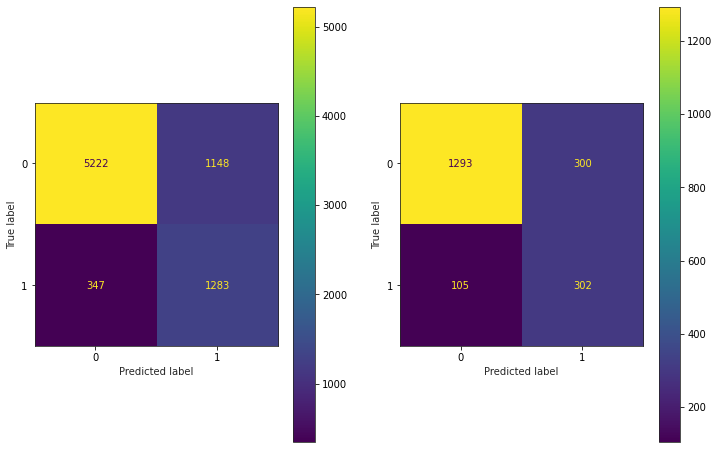

In [143]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))
disp_train.plot(ax = ax.flatten()[0])
disp_test.plot(ax = ax.flatten()[1])
plt.show()

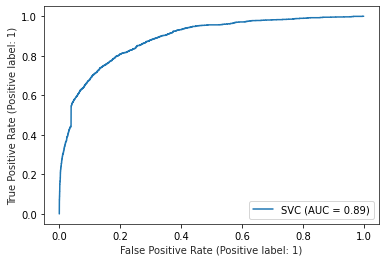

In [144]:
RocCurveDisplay.from_estimator(svc_clf, X_train_f,\
                               y_train)
plt.show()

## Parametric methods - Logistic Regression

In [145]:
lr_clf = LogisticRegression(class_weight = "balanced", C = 0.01)
lr_clf.fit(X_train_f,y_train)

LogisticRegression(C=0.01, class_weight='balanced')

In [146]:
print(f"Train ROC score: {round(roc_auc_score(y_train,lr_clf.predict_proba(X_train_f)[:,-1]),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test ROC score: {round(roc_auc_score(y_test,lr_clf.predict_proba(X_test_f)[:,-1]),3)}")

Train ROC score: 0.77
Test ROC score: 0.778


In [147]:
print(f"Train f2 score: {round(fbeta_score(y_train,lr_clf.predict(X_train_f), average='macro', beta=2),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test f2 score: {round(fbeta_score(y_test,lr_clf.predict(X_test_f), average='macro', beta=2),3)}")

Train f2 score: 0.675
Test f2 score: 0.679


In [148]:
disp_train = ConfusionMatrixDisplay(confusion_matrix(y_train, lr_clf.predict(X_train_f)))
disp_test = ConfusionMatrixDisplay(confusion_matrix(y_test, lr_clf.predict(X_test_f)))

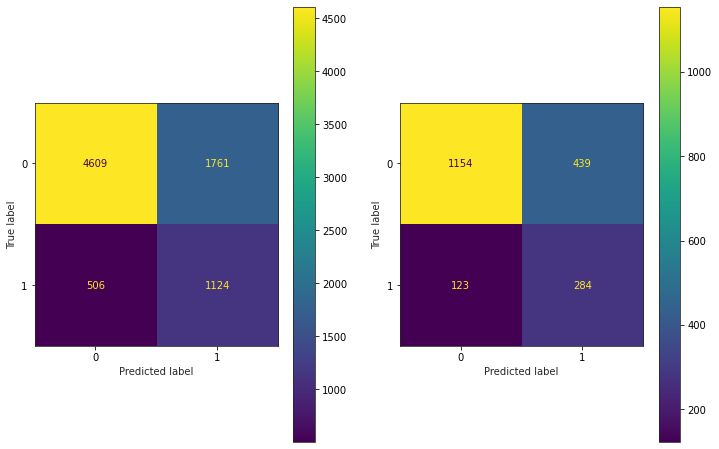

In [149]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))
disp_train.plot(ax = ax.flatten()[0])
disp_test.plot(ax = ax.flatten()[1])
plt.show()

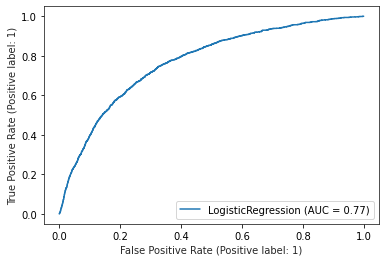

In [150]:
RocCurveDisplay.from_estimator(lr_clf, X_train_f,\
                               y_train)
plt.show()

Note that now, for both the Support Vector Classifier and Logistic Regression cases, we have far fewer false negatives at the expense of far more false positives. However, we also increased the number of true positives, which is the key variable. One could keep increasing $\beta$ as to further penalize the number of false negatives (again tantamount to requiring a lower threshold for identifying a customer as an "exiter") but we shall not conduct this here.

### Understanding the coefficients of logistic regression

One of the great things about parametric methods is that it allows an easier exploration of the results and comparison with one's intuition of what is happening.

In [151]:
{ele : round(lr_clf.coef_[0][i],4) for i, ele in enumerate(X_train_f.columns)}

{'CreditScore': -0.1045,
 'Age': 0.8169,
 'Tenure': -0.0219,
 'Balance': 0.3076,
 'NumOfProducts': -0.0936,
 'EstimatedSalary': 0.0735,
 'Geography_France': -0.2573,
 'Geography_Germany': 0.4447,
 'Geography_Spain': -0.1875,
 'Gender_Female': 0.4301,
 'HasCrCard': -0.0496,
 'IsActiveMember': -0.69}

For the numerical variables, a higher:
1. Credit score leads to a lower probability of exiting;
2. Age leads to a higher probability of exiting. Note that this is the largest coefficient, even after normalizing the input variables;
3. Tenure leads to a lower probability, but it basically irrelevant, matching with the KS test above;
4. Balance leads to a higher probability of exiting;
5. Number of products leads to a lower probability of exiting, but is not very relevant (unlike the results of the KS test above - this might be due to outliers in the "exited" class, see boxplot below);
6. Wage leads to a higher probability, but it almost irrelevant, matching with the KS test above;

For the categorical variables:
1. Being in Germany increases the probability of exiting (see more details in the *Bonus* section below);
2. Being Female increases the probability of exiting;
3. Having a credit card reduces the probability, but is basically irrelevant, matching the chi-squared test above;
4. Being an active member reduces the probability.

# 8. Restricting the analysis to relevant features

**Main conclusions**: After dropping the irrelevant features, performance appears to be slightly worse for the SVC model but nearly identical for the logistic regression.

Dropping the irrelevant features - this is often useful as it makes training faster, let us see if it damages performance:

In [94]:
X_train_f_red = X_train_f.drop(columns = irr_num_f_list + irr_cat_f_list,axis = 1)
X_test_f_red = X_test_f.drop(columns = irr_num_f_list + irr_cat_f_list,axis = 1)

In [95]:
utils.EstimatorGridSearch(X_train_f_red, y_train, models1, \
    params1, score_method = ftwo_scorer)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


,Estimator,Min_score,Mean_score,Max_score,Std_score,C,class_weight,n_estimators,kernel
16,SVC,0.838957,0.851799,0.860893,0.007873,10,None,NaN,rbf
9,RandomForestClassifier,0.841586,0.851098,0.860116,0.006435,NaN,None,500,NaN
8,RandomForestClassifier,0.837621,0.848919,0.860274,0.007506,NaN,None,100,NaN
11,RandomForestClassifier,0.83758,0.848671,0.859989,0.007097,NaN,balanced,500,NaN
14,SVC,0.840386,0.848215,0.854715,0.005779,1,None,NaN,rbf
18,SVC,0.841886,0.847734,0.857472,0.005632,100,None,NaN,rbf
10,RandomForestClassifier,0.835657,0.846918,0.858704,0.007631,NaN,balanced,100,NaN
15,SVC,0.787183,0.797709,0.806629,0.007025,1,balanced,NaN,rbf
17,SVC,0.779439,0.793504,0.800487,0.008327,10,balanced,NaN,rbf
4,LogisticRegression,0.791362,0.792638,0.79587,0.001655,10,None,NaN,NaN


## Parametric methods - Support Vector Classifier

In [96]:
svc_clf = SVC(C=1, class_weight= 'balanced', kernel= 'rbf', probability= True)
svc_clf.fit(X_train_f_red,y_train)

SVC(C=1, class_weight='balanced', probability=True)

In [97]:
print(f"Train ROC score: {round(roc_auc_score(y_train,svc_clf.predict_proba(X_train_f_red)[:,-1]),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test ROC score: {round(roc_auc_score(y_test,svc_clf.predict_proba(X_test_f_red)[:,-1]),3)}")

Train ROC score: 0.873
Test ROC score: 0.85


In [98]:
print(f"Train f2 score: {round(fbeta_score(y_train,svc_clf.predict(X_train_f_red), average='macro', beta=2),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test f2 score: {round(fbeta_score(y_test,svc_clf.predict(X_test_f_red), average='macro', beta=2),3)}")

Train f2 score: 0.808
Test f2 score: 0.794


In [99]:
disp_train = ConfusionMatrixDisplay(confusion_matrix(y_train, svc_clf.predict(X_train_f_red)))
disp_test = ConfusionMatrixDisplay(confusion_matrix(y_test, svc_clf.predict(X_test_f_red)))

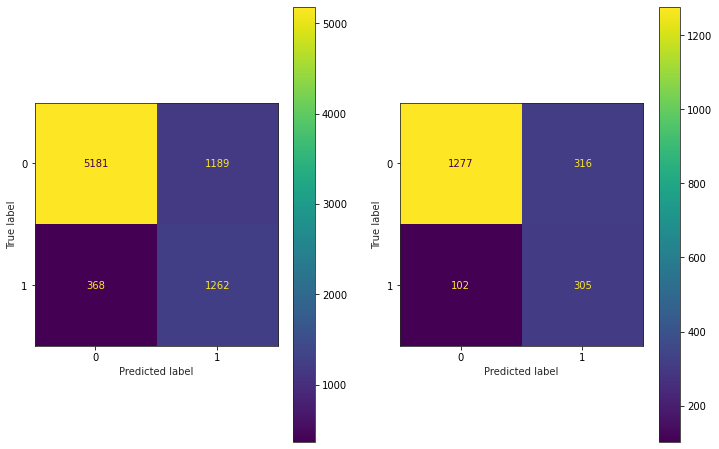

In [100]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))
disp_train.plot(ax = ax.flatten()[0])
disp_test.plot(ax = ax.flatten()[1])
plt.show()

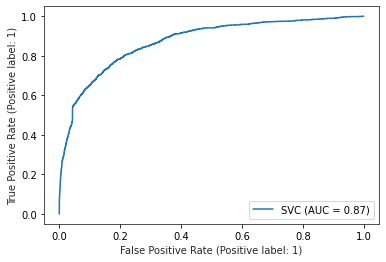

In [101]:
RocCurveDisplay.from_estimator(svc_clf, X_train_f_red,\
                               y_train)
plt.show()

## Parametric methods - Logistic Regression

In [102]:
lr_clf = LogisticRegression(class_weight = 'balanced', C = 0.01)
lr_clf.fit(X_train_f_red,y_train)

LogisticRegression(C=0.01, class_weight='balanced')

In [103]:
print(f"Train ROC score: {round(roc_auc_score(y_train,lr_clf.predict_proba(X_train_f_red)[:,-1]),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test ROC score: {round(roc_auc_score(y_test,lr_clf.predict_proba(X_test_f_red)[:,-1]),3)}")

Train ROC score: 0.77
Test ROC score: 0.779


In [104]:
print(f"Train f2 score: {round(fbeta_score(y_train,lr_clf.predict(X_train_f_red), average='macro', beta=2),3)}") ##Just picking the second column
## which has the probability of a customer exiting.
print(f"Test f2 score: {round(fbeta_score(y_test,lr_clf.predict(X_test_f_red), average='macro', beta=2),3)}")

Train f2 score: 0.722
Test f2 score: 0.726


In [105]:
disp_train = ConfusionMatrixDisplay(confusion_matrix(y_train, lr_clf.predict(X_train_f_red)))
disp_test = ConfusionMatrixDisplay(confusion_matrix(y_test, lr_clf.predict(X_test_f_red)))

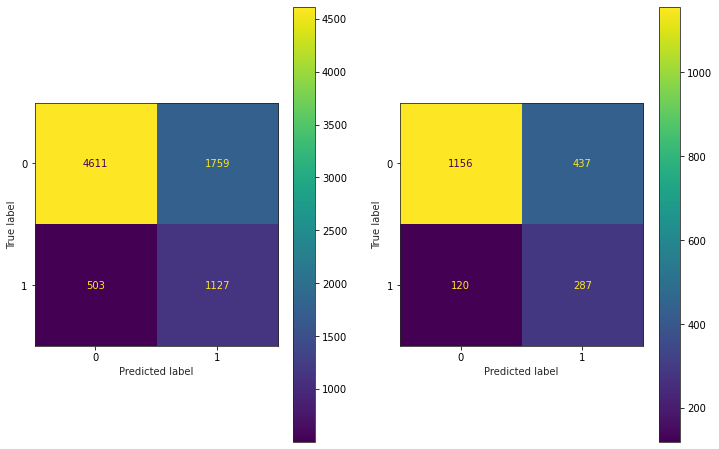

In [106]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))
disp_train.plot(ax = ax.flatten()[0])
disp_test.plot(ax = ax.flatten()[1])
plt.show()

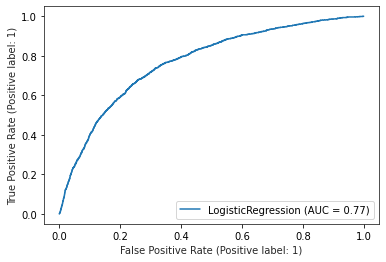

In [107]:
RocCurveDisplay.from_estimator(lr_clf, X_train_f_red,\
                               y_train)
plt.show()

It looks like performance is slightly worse for the SVC case but nearly identical for the logistic regression case.

# 9. Conclusions

1. The most important features for churn prediction are `Age`, `NumOfProducts`, `EstimatedSalary`, `CreditScore`, `Balance`, `Geography` and `Gender`.
2. Assuming that the bank's priority is to retain customers (over the incurred costs), our goal is to minimize the number of false negatives and maximize the number of true positives, even if at the expense of false positives. Therefore, we change the target metric to $F_2$. The best performing model under (k=5) cross-validation was Support Vector Classifier with f2-score equal to 0.75. The best performing logistic regression had a f2-score of 0.68, compared to the naïve benchmark score of 0.67. Both models, however, predict far less false negatives.
3. Restricting the analysis to the relevant features identified by the Kolmogorov-Smirnov and Chi-Squared tests leads to a slight underperformance of the SVC but not of the logistic regression.  
4. The model with the engineered features does not improve performance.


## Bonus

Note that both age and estimated salary are higher for clients in Germany - this might be causing Germany to be a relevant variable to the problem.

In [108]:
df.groupby('Geography').agg({'Age':'mean', 'EstimatedSalary': 'mean'})

,Age,EstimatedSalary
Geography,,
France,38.511767,99899.180814
Germany,39.771622,101113.435102
Spain,38.890997,99440.572281


In [109]:
df[df['Exited'] == 1].groupby('Geography').agg({'Age':'mean', 'EstimatedSalary': 'mean'})

,Age,EstimatedSalary
Geography,,
France,45.133333,103439.278296
Germany,44.894349,98403.886450
Spain,44.147700,103629.554818


But turns that is actually not the case! Another interesting view of the data is:

In [110]:
df2 = df.groupby('Exited').describe().T

In [111]:
subset = [ele for ele in df2.index if ele[1] in {ele for ele in df2.index.get_level_values(1) if ele not in ['count','max','min']}]

In [112]:
df2.loc[subset]

Exited                                  0              1
CreditScore           mean     651.853196     645.351497
                      std       95.653837     100.321503
                      25%      585.000000     578.000000
                      50%      653.000000     646.000000
                      75%      718.000000     716.000000
Age                   mean      37.408389      44.837997
                      std       10.125363       9.761562
                      25%       31.000000      38.000000
                      50%       36.000000      45.000000
                      75%       41.000000      51.000000
Tenure                mean       5.033279       4.932744
                      std        2.880658       2.936106
                      25%        3.000000       2.000000
                      50%        5.000000       5.000000
                      75%        7.000000       8.000000
Balance               mean   72745.296779   91108.539337
                      std    62848.040701   58360.794816
                      25%        0.000000   38340.020000
                      50%    92072.680000  109349.290000
                      75%   126410.280000  131433.330000
NumOfProducts         mean       1.544267       1.475209
                      std        0.509536       0.801521
                      25%        1.000000       1.000000
                      50%        2.000000       1.000000
                      75%        2.000000       2.000000
HasCrCard             mean       0.707146       0.699067
                      std        0.455101       0.458776
                      25%        0.000000       0.000000
                      50%        1.000000       1.000000
                      75%        1.000000       1.000000
IsActiveMember        mean       0.554565       0.360825
                      std        0.497045       0.480358
                      25%        0.000000       0.000000
                      50%        1.000000       0.000000
                      75%        1.000000       1.000000
EstimatedSalary       mean   99738.391772  101465.677531
                      std    57405.586966   57912.418071
                      25%    50783.490000   51907.720000
                      50%    99645.040000  102460.840000
                      75%   148609.955000  152422.910000
BalanceEstSalaryRatio mean       2.478339       9.352977
                      std       14.803568     238.215765
                      25%        0.000000       0.284769
                      50%        0.703392       0.887100
                      75%        1.446481       1.820143
TenureAgeRatio        mean       0.332920       0.221346
                      std        0.417805       0.302265
                      25%        0.125000       0.083333
                      50%        0.250000       0.176471
                      75%        0.421053       0.285714
CreditScoreAgeRatio   mean      43.202242      28.509266
                      std       45.171306      27.413058
                      25%       25.830460      18.200000
                      50%       34.434783      23.241379
                      75%       47.333333      30.842105